In [1]:
import os 

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks,Input,layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Masking,Dropout,GRU,Layer, Conv1D, Concatenate
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt



In [2]:
masking_value = -99
intermediate_dim = 300
latent_dim = 2
epochs = 100
batch_size = 125
threshold = 125


sequence_length = 20

# Input files don't have column names
dependent_var = ['RUL']#依赖的变量
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i + 1) for i in range(0, 21)]
#输入发动机编号/运行时间/设置/哪个传感器数据/
col_names = index_names + setting_names + sensor_names
not_required_feats = ["s_1","s_2","s_5","s_6","s_8","s_9","s_13","s_14","s_15","s_16","s_17","s_18","s_19","s_20","s_21"]
sensors = [sensors for sensors in sensor_names if sensors not in not_required_feats]

In [3]:
## 读取训练集
#pandas读取数据/True:以，为分割符/names:指定列名
df_train = pd.read_csv('E:\\study\\复现资料\\RUL-RVE\\SIMPAC-2022-58-main\\data/train_FD002.txt',delim_whitespace=True,names=col_names)
df_test = pd.read_csv('E:\研究资料\Remaining-Useful-Life-Estimation-Variational-main\data/test_FD002.txt',delim_whitespace=True,names=col_names)
y_test = pd.read_csv('E:\研究资料\Remaining-Useful-Life-Estimation-Variational-main\data/RUL_FD002.txt',delim_whitespace=True,names=["RUL"])
"""注意：这里UnitNumber=1=测试集的UnitNumber"""
y_test["unit_nr"] = y_test.index+1


In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                            df_op_cond['setting_2'].astype(str) + '_' + \
                            df_op_cond['setting_3'].astype(str)

    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond'] == condition, sensor_names])
        df_train.loc[df_train['op_cond'] == condition, sensor_names] = scaler.transform(
            df_train.loc[df_train['op_cond'] == condition, sensor_names])
        df_test.loc[df_test['op_cond'] == condition, sensor_names] = scaler.transform(
            df_test.loc[df_test['op_cond'] == condition, sensor_names])
    return df_train, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0,
                                                                                                        drop=True)

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements - (sequence_length - 1)), range(sequence_length, num_elements + 1)):
        yield data[start:stop, :]


def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr'] == unit_nr], sequence_length, columns))
                for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array


def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length - 1:num_elements, :]


def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr'] == unit_nr], sequence_length, label)
                 for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array


def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value)  # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:, :] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]


In [5]:

train = add_remaining_useful_life(df_train)
train['RUL'].clip(upper=threshold, inplace=True)
X_train_pre = add_operating_condition(train)
X_test_pre = add_operating_condition(df_test)
X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensor_names)

In [6]:
alpha = 0.2
# exponential smoothing
X_train_pre = exponential_smoothing(X_train_pre, sensor_names, 0, alpha)
X_test_pre = exponential_smoothing(X_test_pre, sensor_names, 0, alpha)

C:\Users\chao\AppData\Local\Temp\ipykernel_24644\269695897.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0,
C:\Users\chao\AppData\Local\Temp\ipykernel_24644\269695897.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	

In [7]:
# train-val split

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()):
    train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_pre['unit_nr'].unique()[val_unit]

    x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
    y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)

    x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
    y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)


In [8]:
# create sequences for test
test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr'] == unit_nr], sequence_length, sensors, -99.))
            for unit_nr in X_test_pre['unit_nr'].unique())
x_test = np.concatenate(list(test_gen)).astype(np.float32)

In [9]:
def fun(x):
    if x >= threshold:
        return threshold
    else:
        return x
y_test['RUL'] = y_test['RUL'].apply(lambda x: fun(x))
y_test = y_test.RUL.values

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(39512, 20, 6)
(39512, 1)
(9307, 20, 6)
(9307, 1)
(259, 20, 6)
(259,)


In [11]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
    def call(self, inputs):
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon
    


In [12]:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
# 定义输入层
inputs = Input(shape=(timesteps, input_dim))


mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding 
lstm_out_bidirectional = Bidirectional(GRU(125))(mask)  # 使用LSTM层作为参数


# VAE2 Z层
mu = Dense(latent_dim)(lstm_out_bidirectional)
sigma = Dense(latent_dim)(lstm_out_bidirectional)


# 使用 Sampling 层从 mu 和 sigma 中采样得到 z
z = Sampling()([mu, sigma])


encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
print(encoder.summary())
# -------------------------------------------------------


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 masking (Masking)              (None, 20, 6)        0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 250)          99750       ['masking[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2)            502         ['bidirectional[0][0]']          
                                                                                            

In [13]:
# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim), name='z_sampling_reg')


reg_intermediate2 = Dense(400,activation='tanh')(reg_latent_inputs)
reg_outputs = Dense(1,name='reg_output')(reg_intermediate2)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------

Model: "regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling_reg (InputLayer)  [(None, 2)]              0         
                                                                 
 dense_2 (Dense)             (None, 400)               1200      
                                                                 
 reg_output (Dense)          (None, 1)                 401       
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
class MltiVAR(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(MltiVAR, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        

    @property
    def metrics(self):
        if self.decoder!=None:
            return [
                self.total_loss_tracker,
                self.kl_loss_tracker,
                self.reg_loss_tracker,
                self.reconstruction_loss_tracker
            ]
        else:
            return [
                self.total_loss_tracker,
                self.kl_loss_tracker,
                self.reg_loss_tracker,
            ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    keras.losses.mse(x, reconstruction)
                )
                total_loss = kl_loss + reg_loss + reconstruction_loss
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
                total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(x, reconstruction)
            )
            
            total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
            total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }


In [15]:
class save_latent_space_viz(Callback):
    def __init__(self, model, data, target):
        self.model = model
        self.data = data
        self.target = target

    def on_train_begin(self, logs={}):
        self.best_val_loss = 100000

    def on_epoch_end(self, epoch, logs=None):
        encoder = self.model.layers[0]
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            viz_latent_space(encoder, self.data, self.target, epoch, True, False)


def get_callbacks(model, data, target):
    model_callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='C:\\Users\\chao\\Desktop\\多VAE的RUL预测\\BiGRU结果保存\\FD002\\checkpoint', monitor='val_loss', mode='min', verbose=1,
                        save_best_only=True, save_weights_only=True)
    ]
    return model_callbacks


In [16]:
def viz_latent_space(encoder, data, targets=[], epoch='Final', show=True):
    z, _, _ = encoder.predict(data)
    plt.figure(figsize=(8, 10))
    if len(targets) > 0:
        cmap = plt.cm.get_cmap("summer")
        plt.scatter(z[:, 0], z[:, 1], c=targets, cmap=cmap)
    else:
        plt.scatter(z[:, 0], z[:, 1])
    plt.xlabel('Time')
    plt.ylabel('degradation process')
    plt.colorbar()
    if show:
        plt.show()

    return z



In [17]:
model = MltiVAR(encoder, regressor)
model_callbacks = get_callbacks(model, x_train, y_train)

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

History = model.fit(x_train, y_train,epochs=epochs,validation_data=(x_val, y_val), batch_size=batch_size,callbacks=model_callbacks)

Epoch 1/100
316/317 [============================>.] - ETA: 0s - loss: 4574.2750 - kl_loss: 121.1217 - reg_loss: 2299.0957
Epoch 1: val_loss improved from inf to 945.83899, saving model to C:\Users\chao\Desktop\多VAE的RUL预测\BiGRU结果保存\FD002\checkpoint
317/317 [==============================] - 24s 54ms/step - loss: 4560.6936 - kl_loss: 120.8988 - reg_loss: 2293.9370 - val_loss: 945.8390 - val_kl_loss: 24.6075 - val_reg_loss: 921.2315
Epoch 2/100
317/317 [==============================] - ETA: 0s - loss: 568.1901 - kl_loss: 33.2508 - reg_loss: 475.5962
Epoch 2: val_loss improved from 945.83899 to 676.21014, saving model to C:\Users\chao\Desktop\多VAE的RUL预测\BiGRU结果保存\FD002\checkpoint
317/317 [==============================] - 14s 43ms/step - loss: 568.0034 - kl_loss: 33.2508 - reg_loss: 475.5962 - val_loss: 676.2101 - val_kl_loss: 8.1640 - val_reg_loss: 668.0461
Epoch 3/100
316/317 [============================>.] - ETA: 0s - loss: 401.3296 - kl_loss: 17.9982 - reg_loss: 365.4900
Epoch 3: va

In [24]:
model.load_weights('C:\\Users\\chao\\Desktop\\多VAE的RUL预测\\BiGRU结果保存\\FD002\\checkpoint')

dict_keys(['loss', 'kl_loss', 'reg_loss', 'val_loss', 'val_kl_loss', 'val_reg_loss'])


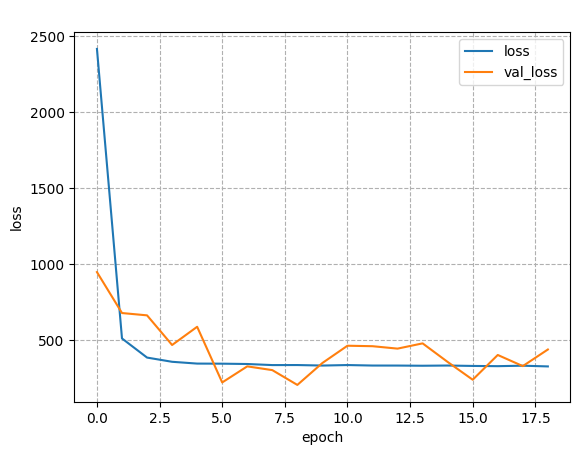

In [25]:
def plotTrainHistory(model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    
    plt.show()
    
print(History.history.keys())
plotTrainHistory(History)

1526/1526 [==============================] - 7s 5ms/step


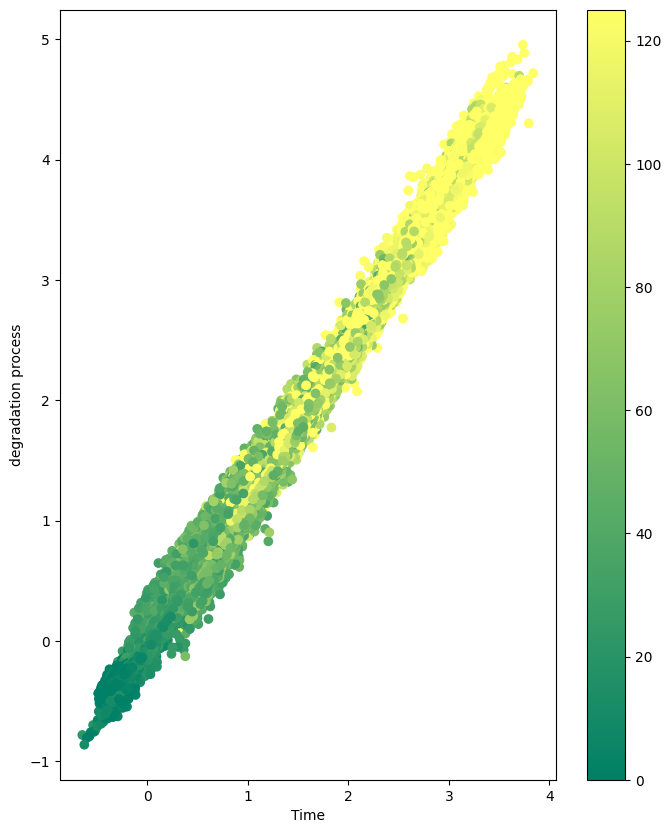

9/9 [==============================] - 0s 4ms/step


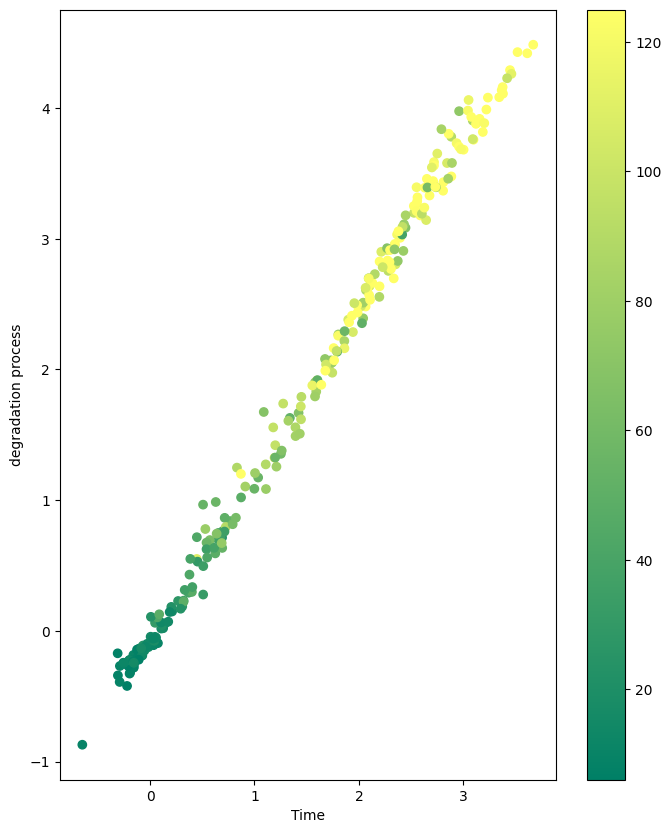

In [26]:
train_mu = viz_latent_space(model.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = viz_latent_space(model.encoder, x_test, y_test)


In [27]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


def score(y_true, y_hat):
    res = 0
    for true, hat in zip(y_true, y_hat):
        subs = hat - true
        if subs < 0:
            res = res + np.exp(-subs / 13)[0] - 1
        else:
            res = res + np.exp(subs / 10)[0] - 1
    print("score: ", res)

    
    
# Evaluate
y_hat_train = model.regressor.predict(train_mu)
y_hat_test = model.regressor.predict(test_mu)

evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
RMSE=evaluate(y_test, y_hat_test, 'test')
score=score(y_test, y_hat_test)

9/9 [==============================] - 0s 1ms/step
train set RMSE:17.996755599975586, R2:0.814992639280665
test set RMSE:17.812856617552416, R2:0.8279091422187348
score:  2858.1312878131866


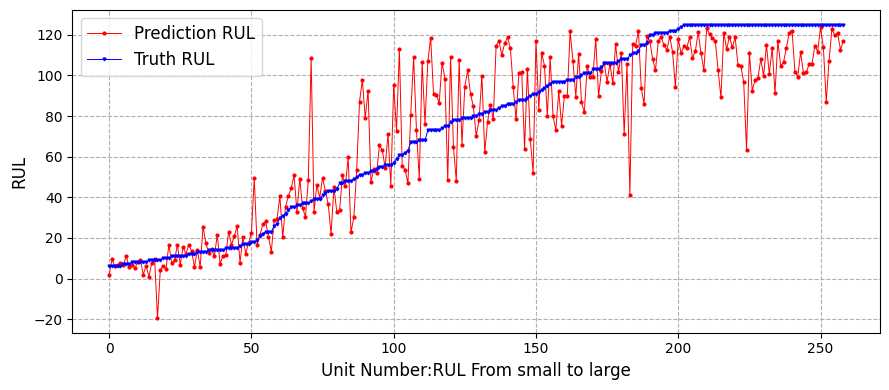

In [28]:
argsort=np.argsort(y_test)
y_test1=y_test[argsort]
y_hat_test1=y_hat_test[argsort]

"""测试集所有unitNumber的最后一个值进行可视化"""
from sklearn.metrics import mean_squared_error
#RMSE = RMSE(y_test, y_hat_test)
#score=score(y_test, y_hat_test)
fig=plt.figure(figsize=(9,4))
plt.grid(linestyle="--")
plt.plot(y_hat_test1, color='red', label='Prediction RUL',linestyle='-', marker='o', markersize=2, linewidth=0.7)
plt.plot(y_test1, color='blue', label='Truth RUL',linestyle='-',marker='v', markersize=2, linewidth=0.7)
#plt.title(dataset,fontsize=12)
plt.ylabel('RUL',fontsize=12)
plt.xlabel('Unit Number:RUL From small to large' ,fontsize=12)
plt.legend(loc='upper left',fontsize=12)
fig.tight_layout()
#plt.savefig(save_dir+'FD001_Last_point_Pre.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()